# ***CommonLit EDA***
***The format of this EDA is based on<br>https://www.kaggle.com/code/fulrose/fkms-data-generation/notebook***<br>
Inspired by [@fulrose](https://www.kaggle.com/fulrose)'s new [book](https://m.yes24.com/Goods/Detail/120528346). 

## If you liked my approach, please give an upvote, Thank you!

### 230818 Update
This idea just came across my mind:<br>
The original scores on the trainset should have scored the texts without any modification on them.<br>
Misspelled words can also be one of the scoring metric, so it seems like fixing the misspelled words might not be the right solution to get better LB score.

## Total 4 spell checkers compared
### 1. TextBlob<br>2. PySpellChecker<br>3. SymSpell<br>4. AutoCorrect

#### ***Ver 18 & 19 --> Added custom dataset for symspellpy and pyspellchecker***
***Ver 16 & 17 --> Added Word Cloud Comparison for original train dataset***<br>
***Ver 15 --> Error Fixed***<br>
***Ver 14 --> Detected misspelled words with PySpellChecker, and Replaced them with SymSpell.<br>Still an error ongoing with the replacement logic***<br>
***Ver 9 ~ 13 --> Updated AutoCorrect, SymSpell for SpellCheck Comparison***<br>
***Ver 7 & 8--> Compared TextBlob and SpellChecker***<br>
***Ver 6 --> Took care of miss spelled words***<br>
***Ver 5 --> added bookmarks***<br>

# Installing Libraries & Locating Input Files

In [1]:
!pip install -qqq pyspellchecker autocorrect symspellpy -U textblob

### For the actual competition, you can add this [dataset](https://www.kaggle.com/datasets/jasonheesanglee/symspell-677) to your input and install symspellpy through the code below.
##### You will not be able to install symspellpy by simple pip install, due to no internet connection.

!pip install /kaggle/input/symspell-677/editdistpy-0.1.3-cp310-cp310-linux_x86_64.whl
!pip install /kaggle/input/symspell-677/symspellpy-6.7.7-py3-none-any.whl

#### For pyspellcheck, please add this [dataset](https://www.kaggle.com/datasets/dmitriygakh/nlp-set) to your input by [@dmitriygakh](https://www.kaggle.com/dmitriygakh).

!pip install /kaggle/input/nlp-set/nlp_set/whl/pyspellchecker-0.7.2-py3-none-any.whl

In [2]:
import warnings
warnings.filterwarnings(action='ignore')
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt

from textblob import TextBlob
from textblob import Word
from spellchecker import SpellChecker
from symspellpy import SymSpell, Verbosity
from autocorrect import Speller

from itertools import islice
import pkg_resources

import unidecode
from wordcloud import WordCloud
from PIL import Image
import nltk
from nltk.corpus import stopwords
from stop_words import get_stop_words
import string
import math, os
import unidecode
import tensorflow as tf
import transformers
from transformers import BertTokenizerFast
from tqdm.auto import tqdm



for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/wordcloud-mask/tragedy.jpg
/kaggle/input/wordcloud-mask/3rdwave.jpg
/kaggle/input/wordcloud-mask/jungle.jpg
/kaggle/input/wordcloud-mask/egypt.jpg
/kaggle/input/symspell-677/symspell_freq_dict.txt
/kaggle/input/symspell-677/frequency_dictionary_en_82_765.txt
/kaggle/input/symspell-677/symspellpy-6.7.7-py3-none-any.whl
/kaggle/input/symspell-677/editdistpy-0.1.3-cp310-cp310-linux_x86_64.whl
/kaggle/input/symspell-677/frequency_bigramdictionary_en_243_342.txt
/kaggle/input/commonlit-evaluate-student-summaries/sample_submission.csv
/kaggle/input/commonlit-evaluate-student-summaries/prompts_train.csv
/kaggle/input/commonlit-evaluate-student-summaries/summaries_test.csv
/kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv
/kaggle/input/commonlit-evaluate-student-summaries/prompts_test.csv
/kaggle/input/nlp-set/nlp_set/nltk_data/wordnet31/corpora/wordnet/sentidx.vrb
/kaggle/input/nlp-set/nlp_set/nltk_data/wordnet31/corpora/wordnet/data.adj
/kaggle/input/nlp-se

# Classes & Definitions for<br>TFRecord Generator

In [3]:
base_path = '/kaggle/input/commonlit-evaluate-student-summaries/'

prompts_train = pd.read_csv(base_path + 'prompts_train.csv')
summaries_train = pd.read_csv(base_path + 'summaries_train.csv')

prompts_test = pd.read_csv(base_path + 'prompts_test.csv')
summaries_test = pd.read_csv(base_path + 'summaries_test.csv')

sample_submission = pd.read_csv(base_path + 'sample_submission.csv')

# Dataset

In [4]:
print(f'prompts_train :\n')
display(prompts_train)
print(f'\nsummaries_train.head(5):\n')
summaries_train.iloc[:5]

prompts_train :



,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."



summaries_train.head(5):



,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757


## Combining separated data into one

In [5]:
train = pd.merge(prompts_train, summaries_train, on='prompt_id', how='left')
print(f'train_combined :\n')
train.iloc[:5]

train_combined :



,prompt_id,prompt_question,prompt_title,prompt_text,student_id,text,content,wording
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,00791789cc1f,1 element of an ideal tragedy is that it shoul...,-0.210614,-0.471415
1,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,0086ef22de8f,The three elements of an ideal tragedy are: H...,-0.970237,-0.417058
2,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,0094589c7a22,Aristotle states that an ideal tragedy should ...,-0.387791,-0.584181
3,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,00cd5736026a,One element of an Ideal tragedy is having a co...,0.088882,-0.594710
4,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,00d98b8ff756,The 3 ideal of tragedy is how complex you need...,-0.687288,-0.460886


In [6]:
test = pd.merge(prompts_test, summaries_test, on='prompt_id', how='left')
print(f'test_combined :\n')
test

test_combined :



,prompt_id,prompt_question,prompt_title,prompt_text,student_id,text
0,abc123,Summarize...,Example Title 1,Heading\nText...,000000ffffff,Example text 1
1,abc123,Summarize...,Example Title 1,Heading\nText...,222222cccccc,Example text 3
2,def789,Summarize...,Example Title 2,Heading\nText...,111111eeeeee,Example text 2
3,def789,Summarize...,Example Title 2,Heading\nText...,333333dddddd,Example text 4


In [7]:
print(f'Shape of train data is {train.shape}')
print(f'Shape of test data is {test.shape}')

Shape of train data is (7165, 8)
Shape of test data is (4, 6)


# Target column description

In [8]:
print(f"Train content description:\n{train['content'].describe()}")

print(f"\nTrain wording description:\n{train['wording'].describe()}")

Train content description:
count    7165.000000
mean       -0.014853
std         1.043569
min        -1.729859
25%        -0.799545
50%        -0.093814
75%         0.499660
max         3.900326
Name: content, dtype: float64

Train wording description:
count    7165.000000
mean       -0.063072
std         1.036048
min        -1.962614
25%        -0.872720
50%        -0.081769
75%         0.503833
max         4.310693
Name: wording, dtype: float64


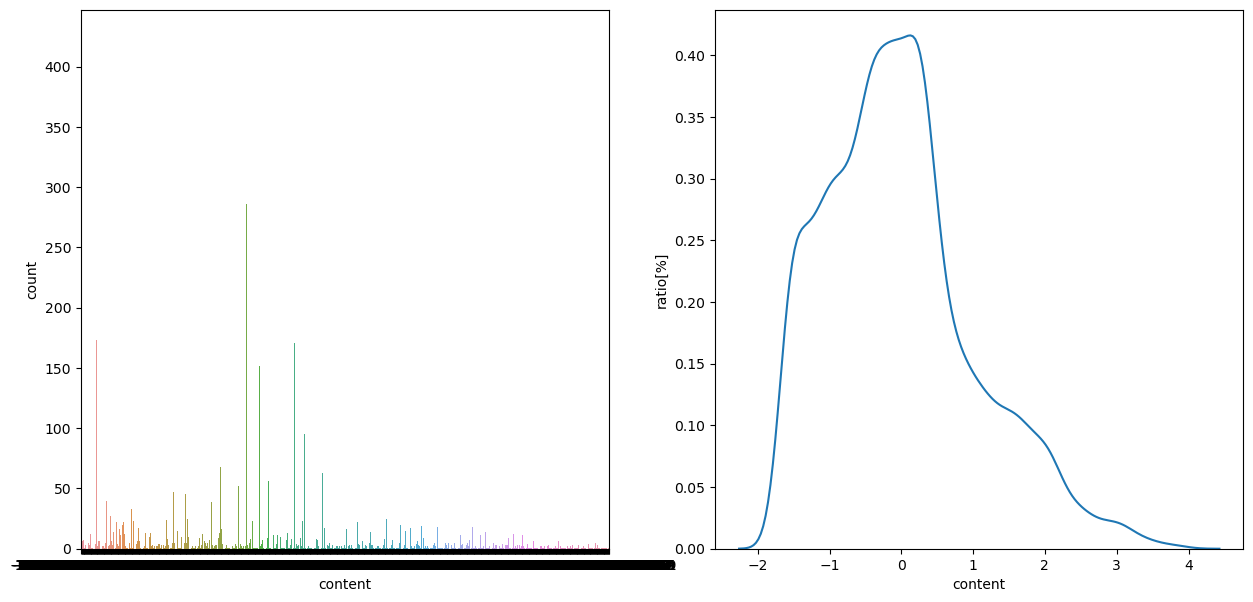

In [9]:
main_cols = [column for column in train]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 7))
sns.countplot(x='content', data=train, ax=ax1)
sns.kdeplot(train.loc[train['content']>-2, 'content'], ax=ax2)
ax2.set_ylabel('ratio[%]')
ax2.set_xlabel('content')
plt.show()

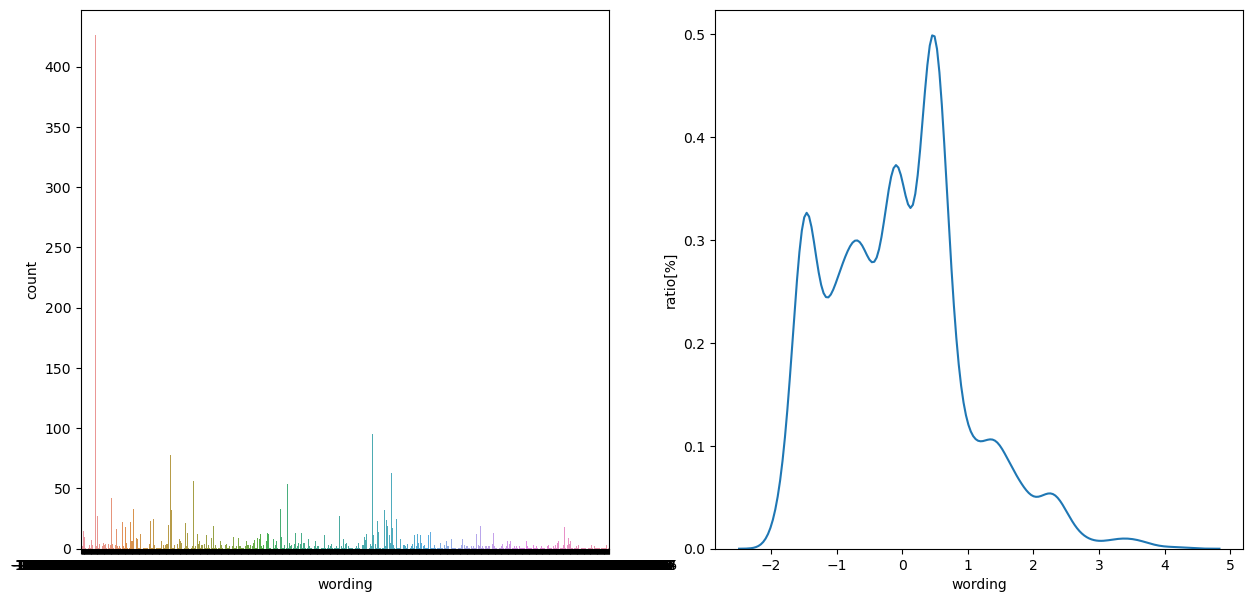

In [10]:
main_cols = [column for column in train]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 7))
sns.countplot(x='wording', data=train, ax=ax1)
sns.kdeplot(train.loc[train['wording']>-2, 'wording'], ax=ax2)
ax2.set_ylabel('ratio[%]')
ax2.set_xlabel('wording')
plt.show()

# Stop words & addition

In [11]:
stop_words = stopwords.words('english')
print(f'stop_words[-15:]:\n{stop_words[-15:]}\n')
_stop_words = list(get_stop_words('en'))
stop_words.extend(_stop_words)
additional_words = ['also', 'day', 'would', 'could', 'made', 'make', 'else', 'either', 'neither', 'may', 'must']
stop_words.extend(additional_words)
print(f'stop_words[-15:]:\n{stop_words[-15:]}\n')

stop_words[-15:]:
["mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

stop_words[-15:]:
['your', 'yours', 'yourself', 'yourselves', 'also', 'day', 'would', 'could', 'made', 'make', 'else', 'either', 'neither', 'may', 'must']



# Word Cloud, Text Statistic, Num Words<br> before Preprocessing & Misspell detection

In [12]:
train_prompt_id_list = list(set(train['prompt_id']))
train_prompt_id_list

['814d6b', '3b9047', 'ebad26', '39c16e']

In [13]:
def generate_word_cloud(df, col_name, prompt, prompt_id, title, min_score=-2, mask_path=None):
    text_list = df[(df['prompt_id']==prompt_id)&(df[col_name] > min_score)][prompt].tolist()
    texts = " ".join(text_list*3).lower()
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.set_title(f'{title}' , fontsize=20)
    
    if mask_path != None:
        mask = Image.open(mask_path)
        mask = np.array(mask)
        wc = WordCloud(max_font_size=50,
                       min_font_size=10,
                       max_words=500,
                       background_color="black",
                       color_func=lambda *args, **kwargs: "white",
                       stopwords=stop_words,
                       mask=mask
                      )
    else:
        wc = WordCloud(max_font_size=50,
                       min_font_size=10,
                       max_words=500,
                       background_color="black",
                       color_func=lambda *args, **kwargs: "white",
                       stopwords=stop_words
                      )

    wc.generate(texts)
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
    plt.show()

In [14]:
# text statistic
# number of words in the text
def text_description(train_df, test_df, column, prompt_id):
    train_df['num_words'] = train_df[train_df['prompt_id']==prompt_id][column].apply(lambda sen : len(str(sen).split()))
    test_df['num_words'] = test_df[test_df['prompt_id']==prompt_id][column].apply(lambda sen : len(str(sen).split()))

    # number of unique words in the text
    train_df['num_unique_words'] = train_df[train_df['prompt_id']==prompt_id][column].apply(lambda sen: len(set(str(sen).split())))
    test_df['num_unique_words'] = test_df[test_df['prompt_id']==prompt_id][column].apply(lambda sen: len(set(str(sen).split())))

    # number of characters in the text
    train_df['num_chars'] = train_df[train_df['prompt_id']==prompt_id][column].apply(len)
    test_df['num_chars'] = test_df[test_df['prompt_id']==prompt_id][column].apply(len)

    # number of stopwords
    train_df["num_stopwords"] = train_df[train_df['prompt_id']==prompt_id][column].apply(lambda sen: len([w for w in str(sen).lower().split() if w in stop_words]))
    test_df["num_stopwords"] = test_df[test_df['prompt_id']==prompt_id][column].apply(lambda sen: len([w for w in str(sen).lower().split() if w in stop_words]))

    # number of punctuations in the text 
    train_df["num_punctuations"] = train_df[train_df['prompt_id']==prompt_id][column].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
    test_df["num_punctuations"] = test_df[test_df['prompt_id']==prompt_id][column].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

    # number of title case words in the text 
    train_df["num_words_upper"] = train_df[train_df['prompt_id']==prompt_id][column].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
    test_df["num_words_upper"] = test_df[test_df['prompt_id']==prompt_id][column].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

    # number of title case words in the text
    train_df["num_words_title"] = train_df[train_df['prompt_id']==prompt_id][column].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
    test_df["num_words_title"] = test_df[test_df['prompt_id']==prompt_id][column].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

    # average length of the words in the text
    train_df["mean_word_len"] = train_df[train_df['prompt_id']==prompt_id][column].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    test_df["mean_word_len"] = test_df[test_df['prompt_id']==prompt_id][column].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

    pd.set_option('float_format', '{:.4f}'.format)

    stat_cols = ["num_words", "num_unique_words", 
                 "num_chars", "num_stopwords", "num_punctuations", 
                 "num_words_upper", "num_words_title", "mean_word_len"]

    return train_df[stat_cols].describe(), test_df[stat_cols].describe()

In [15]:
def num_words_plot(df, column, prompt_id, title):
    plt.figure(figsize=(14,4))
    sns.distplot(df[df['prompt_id']==prompt_id][column], bins=100) # column = num_words
    plt.title(title, fontsize=25)
    plt.show()

0it [00:00, ?it/s]

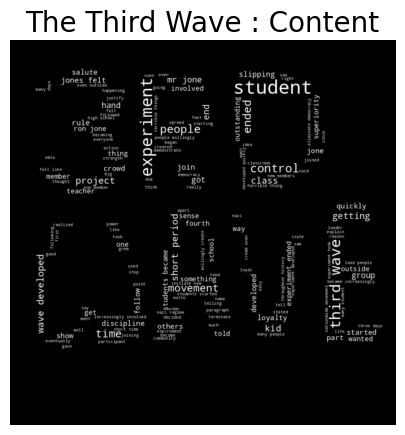

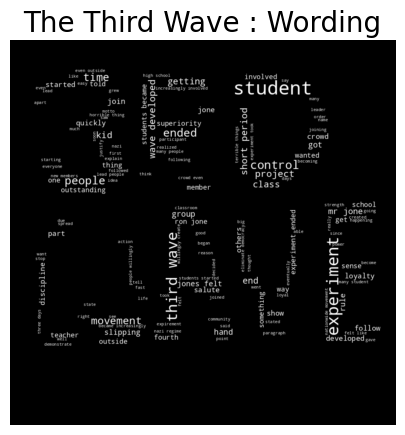

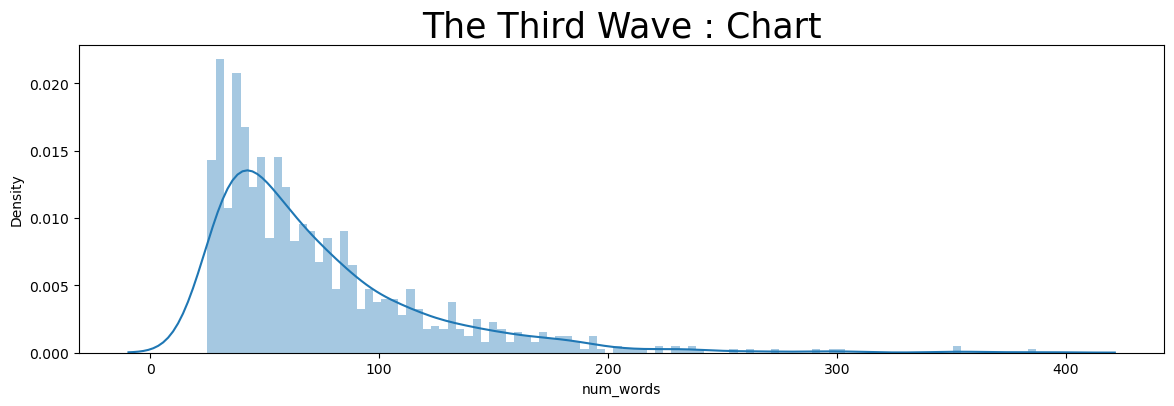

,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len
count,1103.0000,1103.0000,1103.0000,1103.0000,1103.0000,1103.0000,1103.0000,1103.0000
mean,72.8740,52.3753,411.8513,37.7144,6.3400,0.0689,5.6908,4.6200
std,46.7222,26.3628,270.3186,23.9258,6.1569,0.2870,4.5338,0.3379
min,25.0000,20.0000,118.0000,10.0000,0.0000,0.0000,0.0000,3.4333
25%,40.0000,33.0000,221.0000,21.0000,3.0000,0.0000,2.0000,4.4000
50%,59.0000,45.0000,332.0000,30.0000,4.0000,0.0000,5.0000,4.6250
75%,90.0000,64.5000,507.5000,47.0000,8.0000,0.0000,8.0000,4.8391
max,387.0000,218.0000,2297.0000,182.0000,59.0000,3.0000,36.0000,5.7931


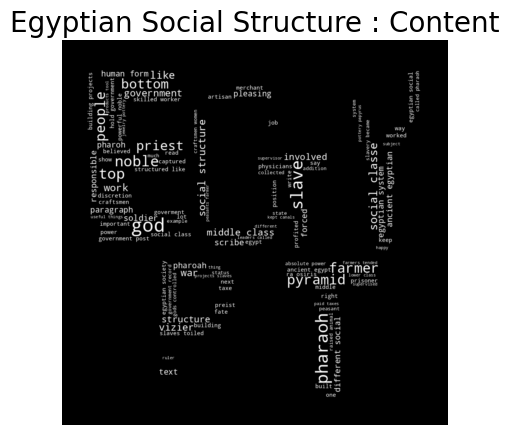

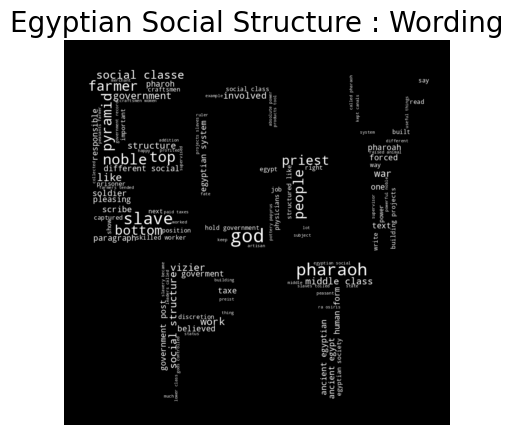

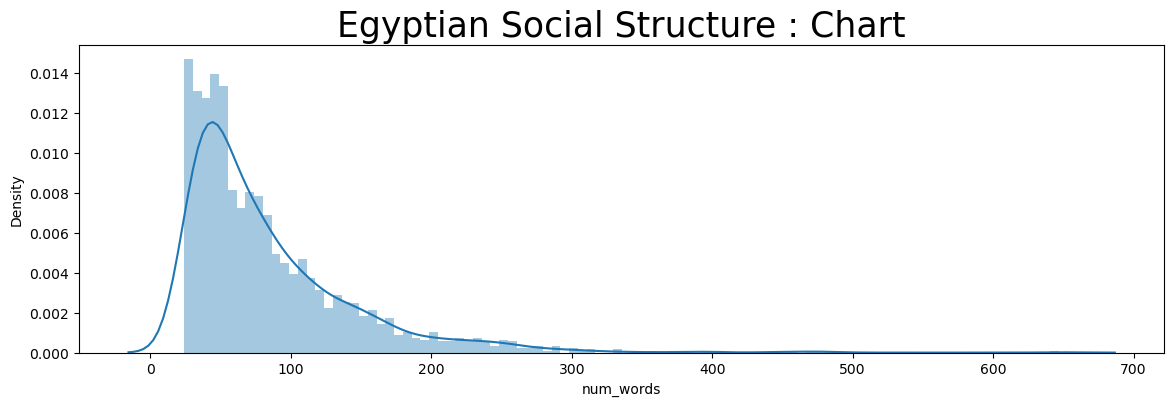

,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len
count,2009.0000,2009.0000,2009.0000,2009.0000,2009.0000,2009.0000,2009.0000,2009.0000
mean,83.5316,56.6341,488.8900,41.3365,11.6426,0.1867,6.9582,4.8131
std,60.4770,33.9581,360.4702,29.7604,11.8796,1.1533,6.6417,0.4414
min,24.0000,17.0000,114.0000,5.0000,0.0000,0.0000,0.0000,3.2955
25%,42.0000,32.0000,244.0000,21.0000,4.0000,0.0000,3.0000,4.5478
50%,65.0000,47.0000,374.0000,32.0000,8.0000,0.0000,5.0000,4.8065
75%,106.0000,71.0000,611.0000,53.0000,15.0000,0.0000,9.0000,5.0704
max,647.0000,332.0000,3940.0000,307.0000,162.0000,41.0000,81.0000,7.0156


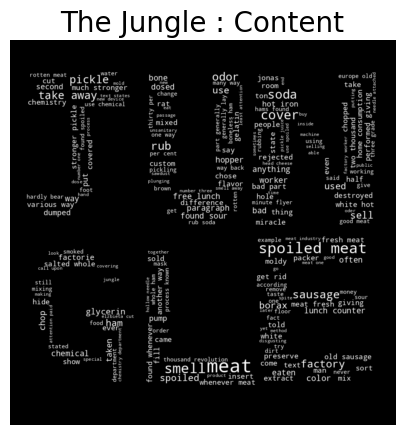

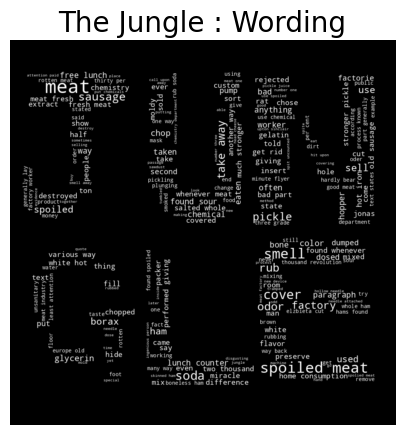

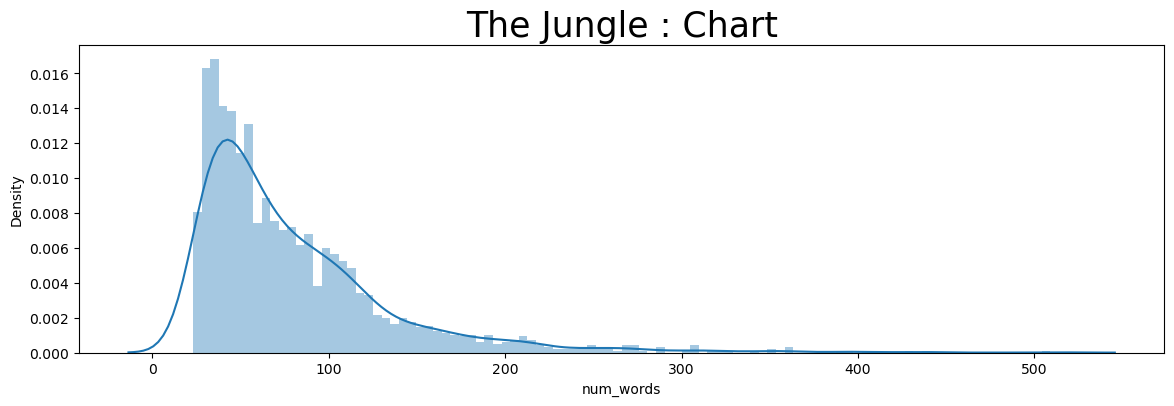

,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len
count,1996.0000,1996.0000,1996.0000,1996.0000,1996.0000,1996.0000,1996.0000,1996.0000
mean,79.4509,54.5040,420.7560,42.1242,10.3472,0.0521,3.6844,4.2630
std,55.6905,30.2666,302.9265,29.4349,9.2133,0.3155,3.3914,0.3110
min,23.0000,18.0000,115.0000,8.0000,0.0000,0.0000,0.0000,3.2581
25%,41.0000,32.0000,214.0000,22.0000,4.0000,0.0000,2.0000,4.0522
50%,63.0000,47.0000,330.0000,33.0000,8.0000,0.0000,3.0000,4.2500
75%,100.0000,68.0000,527.2500,53.2500,14.0000,0.0000,5.0000,4.4458
max,509.0000,252.0000,2775.0000,257.0000,88.0000,8.0000,30.0000,5.8947


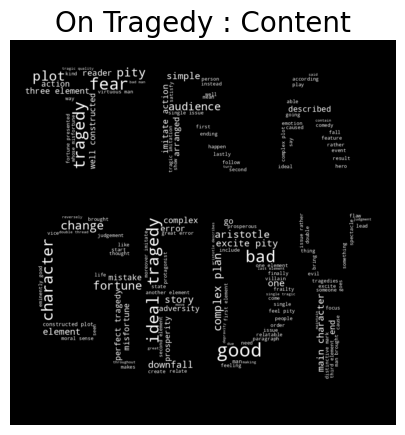

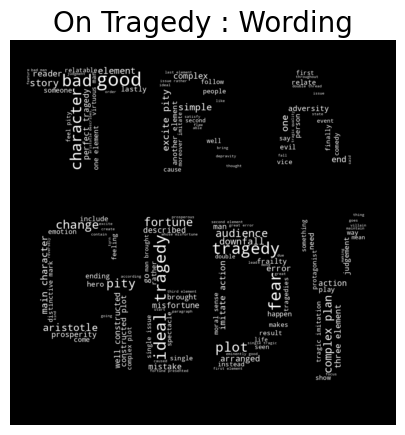

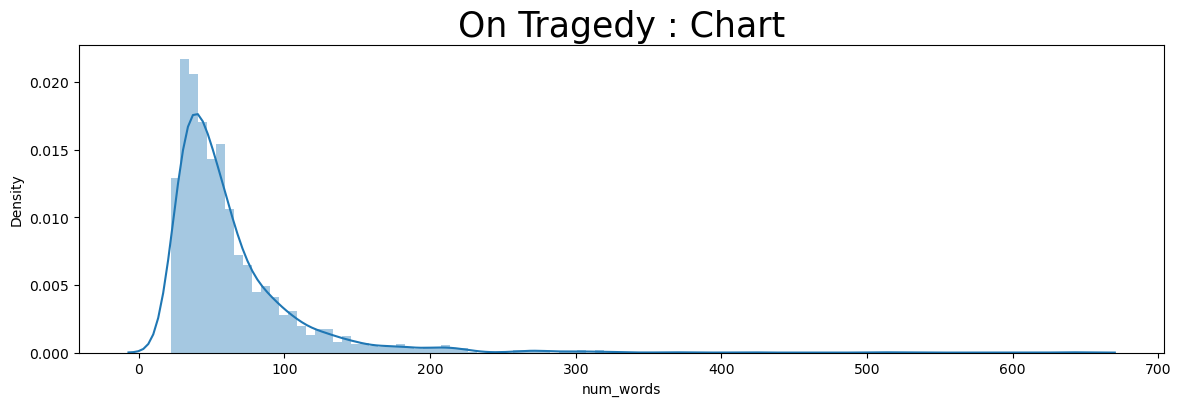

,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len
count,2057.0000,2057.0000,2057.0000,2057.0000,2057.0000,2057.0000,2057.0000,2057.0000
mean,62.8328,45.3500,352.0933,32.2635,7.7749,0.2965,3.6582,4.5803
std,44.5253,23.9886,256.5065,22.6293,7.6694,0.6020,3.0923,0.3425
min,22.0000,13.0000,125.0000,7.0000,0.0000,0.0000,0.0000,3.2821
25%,36.0000,30.0000,199.0000,19.0000,3.0000,0.0000,2.0000,4.3443
50%,50.0000,39.0000,278.0000,26.0000,5.0000,0.0000,3.0000,4.5789
75%,73.0000,53.0000,409.0000,38.0000,9.0000,0.0000,4.0000,4.7993
max,641.0000,315.0000,3711.0000,323.0000,87.0000,6.0000,33.0000,6.5385


In [16]:
for i, prompt_id in tqdm(enumerate(train_prompt_id_list)):
    if prompt_id == '39c16e':
        generate_word_cloud(df=train, col_name='content', prompt='text', prompt_id=prompt_id ,title='On Tragedy : Content', mask_path='/kaggle/input/wordcloud-mask/tragedy.jpg')
        generate_word_cloud(df=train, col_name='wording', prompt='text', prompt_id=prompt_id ,title='On Tragedy : Wording', mask_path='/kaggle/input/wordcloud-mask/tragedy.jpg')
        train_desc, test_desc = text_description(train_df=train, test_df=test, column='text', prompt_id=prompt_id)
        num_words_plot(df=train, column='num_words', prompt_id=prompt_id, title='On Tragedy : Chart')
        display(train_desc)
        print()
    elif prompt_id == '3b9047':
        generate_word_cloud(df=train, col_name='content', prompt='text', prompt_id=prompt_id , title='Egyptian Social Structure : Content', mask_path='/kaggle/input/wordcloud-mask/egypt.jpg')
        generate_word_cloud(df=train, col_name='wording', prompt='text', prompt_id=prompt_id , title='Egyptian Social Structure : Wording', mask_path='/kaggle/input/wordcloud-mask/egypt.jpg')
        train_desc, test_desc = text_description(train_df=train, test_df=test, column='text', prompt_id=prompt_id)
        num_words_plot(df=train, column='num_words', prompt_id=prompt_id, title='Egyptian Social Structure : Chart')
        display(train_desc)
        print()
    elif prompt_id == 'ebad26':
        generate_word_cloud(df=train, col_name='content', prompt='text', prompt_id=prompt_id , title='The Jungle : Content', mask_path='/kaggle/input/wordcloud-mask/jungle.jpg')
        generate_word_cloud(df=train, col_name='wording', prompt='text', prompt_id=prompt_id , title='The Jungle : Wording', mask_path='/kaggle/input/wordcloud-mask/jungle.jpg')
        train_desc, test_desc = text_description(train_df=train, test_df=test, column='text', prompt_id=prompt_id)
        num_words_plot(df=train, column='num_words', prompt_id=prompt_id, title='The Jungle : Chart')
        display(train_desc)
        print()
    elif prompt_id == '814d6b':
        generate_word_cloud(df=train, col_name='content', prompt='text', prompt_id=prompt_id , title='The Third Wave : Content', mask_path='/kaggle/input/wordcloud-mask/3rdwave.jpg')
        generate_word_cloud(df=train, col_name='wording', prompt='text', prompt_id=prompt_id , title='The Third Wave : Wording', mask_path='/kaggle/input/wordcloud-mask/3rdwave.jpg')
        train_desc, test_desc = text_description(train_df=train, test_df=test, column='text', prompt_id=prompt_id)
        num_words_plot(df=train, column='num_words', prompt_id=prompt_id, title='The Third Wave : Chart')
        display(train_desc)
        print()

# Simple Preprocessing

In [17]:
def text_processor_2(s):
    """
    문장을 담고있는 variable을 넣어주면
    알파벳을 제외한 문장의 모든 기호, 숫자를 제거합니다.

    :param s: 문장을 담고있는 variable
    :return: 새로운 DataFrame안에 담긴 text_processor가 적용된 column
    """

    pattern = r'\([^)]*\)'  # ()
    s = re.sub(pattern=pattern, repl='', string=s)
    pattern = r'\[[^)]*\]'  # []
    s = re.sub(pattern=pattern, repl='', string=s)
    pattern = r'\<[^)]*\>'  # <>
    s = re.sub(pattern=pattern, repl='', string=s)
    pattern = r'\{[^)]*\}'  # {}
    s = re.sub(pattern=pattern, repl='', string=s)
    s = s.replace("'", '')

    pattern = r'[^a-zA-Z0-9]'
    s = re.sub(pattern=pattern, repl=' ', string=s)
    
    s_split = s.split()

    not_list0 = ['isnt', 'arent', 'wasnt','werent',
                 'didnt', 'dont', 'doesnt',
                 'hasnt', 'havent', 'hadnt',
                 'neednt', 'darent',
                 'oughtnt', 'mustnt',
                 'wouldnt', 'couldnt', 'wouldnt', 'shouldnt']
    not_list1 = ['cant', 'wont']
    s_list = []
    for word in s_split:
        if len(word) != 1:
            if word in not_list0:
                s_list.append(word[:-2])
                s_list.append('not')
            elif word == not_list1[0]:
                s_list.append('cannot')
            elif word == not_list1[1]:
                s_list.append('will')
                s_list.append('not')
            else:
                s_list.append(word)

    s = " ".join(s_list)
    
    return s

In [18]:
def preprocessing(df, column):
    df[column] = df[column].map(unidecode.unidecode)
    df[column] = df[column].str.lower()
    df[column] = df[column].str.replace('\r', ' ').str.replace('\n', ' ')
    if column == 'text':
        temp = []
        for row_num in range(df.shape[0]):
            text_row = text_processor_2(df[column][row_num])
            temp.append(text_row)
        df[column] = pd.Series(temp)
    return df

In [19]:
for column in train.columns[:6]:
    train_processed = preprocessing(train, column)
print('train_processed.head(5) :\n')
train_processed.head(5)

train_processed.head(5) :



,prompt_id,prompt_question,prompt_title,prompt_text,student_id,text,content,wording,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len
0,39c16e,summarize at least 3 elements of an ideal trag...,on tragedy,chapter 13 as the sequel to what has already...,00791789cc1f,element of an ideal tragedy is that it should ...,-0.2106,-0.4714,56.0000,34.0000,291.0000,31.0000,3.0000,0.0000,2.0000,4.1964
1,39c16e,summarize at least 3 elements of an ideal trag...,on tragedy,chapter 13 as the sequel to what has already...,0086ef22de8f,the three elements of an ideal tragedy are hav...,-0.9702,-0.4171,25.0000,24.0000,152.0000,12.0000,6.0000,0.0000,3.0000,4.9600
2,39c16e,summarize at least 3 elements of an ideal trag...,on tragedy,chapter 13 as the sequel to what has already...,0094589c7a22,aristotle states that an ideal tragedy should ...,-0.3878,-0.5842,52.0000,44.0000,334.0000,22.0000,26.0000,0.0000,1.0000,5.4231
3,39c16e,summarize at least 3 elements of an ideal trag...,on tragedy,chapter 13 as the sequel to what has already...,00cd5736026a,one element of an ideal tragedy is having comp...,0.0889,-0.5947,58.0000,42.0000,328.0000,30.0000,3.0000,0.0000,4.0000,4.6724
4,39c16e,summarize at least 3 elements of an ideal trag...,on tragedy,chapter 13 as the sequel to what has already...,00d98b8ff756,the ideal of tragedy is how complex you need t...,-0.6873,-0.4609,60.0000,44.0000,328.0000,31.0000,3.0000,0.0000,1.0000,4.4833


In [20]:
for column in test.columns[:6]:
    test_processed = preprocessing(test, column)
print('test_processed.head(5) :\n')
test_processed.head(5)

test_processed.head(5) :



,prompt_id,prompt_question,prompt_title,prompt_text,student_id,text,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len
0,abc123,summarize...,example title 1,heading text...,000000ffffff,example text,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,abc123,summarize...,example title 1,heading text...,222222cccccc,example text,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,def789,summarize...,example title 2,heading text...,111111eeeeee,example text,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,def789,summarize...,example title 2,heading text...,333333dddddd,example text,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Spell Check

### I originally used TextBlob to replace the miss spelled words.
However, as [@friendofsatoshi](https://www.kaggle.com/friendofsatoshi) mentioned that pyspellchecker works way better ([here](https://www.kaggle.com/competitions/commonlit-evaluate-student-summaries/discussion/428941)), I had to compare them.



In [21]:
symspell_freq_dict = pd.read_csv('/kaggle/input/symspell-677/symspell_freq_dict.txt', sep = " ", engine='python')
symspell_freq_dict = symspell_freq_dict.set_axis(axis=1, labels=['word', 'key'])
the_temp = pd.DataFrame({'word': ['the'], 'key':[23135851162]})
symspell_freq_dict = pd.concat([symspell_freq_dict.reset_index(), the_temp]).sort_index().drop(columns='index').reset_index().drop(columns='index')
print('symspell_freq_dict=\n')
symspell_freq_dict.head(5)

symspell_freq_dict=



,word,key
0,of,13151942776
1,the,23135851162
2,and,12997637966
3,to,12136980858
4,a,9081174698


In [22]:
# manual grammarly 
s = "I started my schooling as the majority did in my area, at the local primarry school. I thenwent to the local secondarry school and recieved grades in English, Maths, Phisics,Biology, Geography, Art, Graphical Comunication and Philosophy of Religeon. I'll not bore you with the 'A' levels and above. Notice the ambigous English qualification above. It was, in truth, a cource dedicated to reading 'Lord of the flies' and other gems, and a weak atempt at getting us to commprehend them. Luckilly my middle-class upbringing gave me a head start as I was already aquainted with that sort of langauge these books used (and not just the Peter and Jane books) and had read simillar books before. I will never be able to put that paticular course down as much as I desire to because, for all its faults, it introduced me to Steinbeck, Malkovich and the wonders of Lenny, mice and pockets."
print(f'original_sentence =\n{s}'
'number of miss spelled words detected by grammarly: 16\n\
\ngrammarly detected wrong words:\n\
primarry,\n\
thenwent,\n\
secondarry,\n\
recieved,\n\
Phisics,\n\
Comunication,\n\
Religeon,\n\
ambigous,\n\
cource,\n\
atempt,\n\
commprehend,\n\
Luckilly,\n\
aquainted,\n\
langauge,\n\
simillar,\n\
paticular\n\
')
grammarly_corrected_words = "I started my schooling as the majority did in my area, at the local primary school. I then went to the local secondary school and received grades in English, Maths, Physics,Biology, Geography, Art, Graphical communication and Philosophy of Religion. I'll not bore you with the 'A' levels and above. Notice the ambiguous English qualification above. It was, in truth, a course dedicated to reading 'Lord of the flies' and other gems, and a weak attempt at getting us to comprehend them. Luckily my middle-class upbringing gave me a head start as I was already acquainted with that sort of language these books used (and not just the Peter and Jane books) and had read similar books before. I will never be able to put that particular course down as much as I desire to because, for all its faults, it introduced me to Steinbeck, Malkovich and the wonders of Lenny, mice and pockets."
print(f'\n{grammarly_corrected_words}')

original_sentence =
I started my schooling as the majority did in my area, at the local primarry school. I thenwent to the local secondarry school and recieved grades in English, Maths, Phisics,Biology, Geography, Art, Graphical Comunication and Philosophy of Religeon. I'll not bore you with the 'A' levels and above. Notice the ambigous English qualification above. It was, in truth, a cource dedicated to reading 'Lord of the flies' and other gems, and a weak atempt at getting us to commprehend them. Luckilly my middle-class upbringing gave me a head start as I was already aquainted with that sort of langauge these books used (and not just the Peter and Jane books) and had read simillar books before. I will never be able to put that paticular course down as much as I desire to because, for all its faults, it introduced me to Steinbeck, Malkovich and the wonders of Lenny, mice and pockets.number of miss spelled words detected by grammarly: 16

grammarly detected wrong words:
primarry,
th

In [23]:
def textblob_correction(sentence):
    try:
        sentence = re.sub(r'[^\w\s]','',sentence)
        
        corrected = ''
        misspelled_words = []
        corrected_words = []
        for word in tqdm(sentence.split()):
            w = str(TextBlob(word).correct())
            corrected = corrected + ' ' + w
            if word != w:
                misspelled_words.append(word)
                corrected_words.append(w)
        
        misspelled_words_count = 0
        for word in corrected:
            if word in misspelled_words:
                misspelled_words_count +=1
                
        return corrected, misspelled_words, corrected_words, len(misspelled_words) - misspelled_words_count
    
    except UnicodeDecodeError:
        return sentence
    
def spell_checker(sentence):
    try:
        sentence = re.sub(r'[^\w\s]','',sentence)
        spell = SpellChecker()
        tokens = nltk.word_tokenize(sentence)
        text_length = len(tokens)

        mis_tokens = [token for token in spell.unknown(tokens) if token.isalpha()]
        temp = []
        corrected_words = []
        for word in tqdm(mis_tokens):
            corrected_word = spell.correction(word)
            temp.append({word : corrected_word})
            corrected_words.append(corrected_word)
        
            
        temp_1 = []
        for word in tokens:
            for set_ in temp:
                if list(set_.keys())[0] == word:
                    word = list(set_.values())[0]
                    if word in temp_1:
                        continue
                    else:
                        temp_1.append(word)
            if word in temp_1:
                continue
            else:
                temp_1.append(word)

        final_sentence = ''
        for word in temp_1:
            if word.isalpha() or word.isnumeric() == True:
                final_sentence = final_sentence + word + ' '
            elif word in [',', '.', '"', "'", '(', ')', '[', ']', '{', '}']:
                final_sentence = final_sentence + word
        final_sentence = final_sentence.replace('  ', ' ').strip()

        return final_sentence, mis_tokens, corrected_words, len(mis_tokens)
    except UnicodeDecodeError:
        return sentence
    
def symspellpy_correction(sentence):
    try:
        sentence = re.sub(r'[^\w\s]','',sentence)
        sym_spell = SymSpell(max_dictionary_edit_distance=3, prefix_length=7)
        freq_dict = "/kaggle/input/symspell-677/symspell_freq_dict.txt"
        sym_spell.load_dictionary(freq_dict, term_index=0, count_index=1)
        terms = sym_spell.lookup_compound(sentence, 
                                          max_edit_distance=2) 

        corrected_sentence = terms[0].term

        misspelled_words = []
        corrected_words = []
        for word in tqdm(sentence.lower().split()):
            if word not in list(symspell_freq_dict['word']):
                misspelled_words.append(word)
                corrected_words.append(sym_spell.lookup_compound(word, max_edit_distance=2)[0].term)

        return corrected_sentence, misspelled_words, corrected_words,len(misspelled_words)
    
    except UnicodeDecodeError:
        return sentence

def autocorrect_correction(sentence):
    try:
        spell = Speller(lang='en')
        corrected_sentence = spell(sentence)
        
        misspelled_words = []
        corrected_words = []
        for word in tqdm(sentence.lower().split()):
            w = spell(word)
            if w != word:
                misspelled_words.append(word)
                corrected_words.append(w)
        
        return corrected_sentence, misspelled_words, corrected_words, len(misspelled_words)
        
    except UnicodeDecodeError:
        return sentence

In [24]:
print(f'\n{"*"*10+" textblob_correction "+"*"*10}\n\n')

cor_sent, mis_spell, corrected_words, num_mis_spell = textblob_correction(s)
# print(f'textblob_correction =\n{cor_sent}\n\n')
print(f'list of misspelled words =\n{mis_spell}\n\n')
print(f'list of corrected words =\n{corrected_words}\n\n')
print(f'number of misspelled words =\n{num_mis_spell}\n\n')

print(f'{"*"*10+" pyspellchecker_correction "+"*"*10}\n\n')

cor_sent, mis_spell, corrected_words, num_mis_spell = spell_checker(s)
# print(f'pyspellchecker =\n{cor_sent}\n\n\
print(f'list of misspelled words =\n{mis_spell}\n\n\
list of corrected words =\n{corrected_words}\n\n\
number of misspelled words =\n{num_mis_spell}\n\n')

print(f'{"*"*10+" symspellpy_correction "+"*"*10}\n\n')

cor_sent, mis_spell, corrected_words, num_mis_spell = symspellpy_correction(s)
# print(f'symspellpy_correction =\n{cor_sent}\n\n\
print(f'list of misspelled words =\n{mis_spell}\n\n\
list of corrected words =\n{corrected_words}\n\n\
number of misspelled words =\n{num_mis_spell}\n\n')

print(f'{"*"*10+" autocorrect_correction "+"*"*10}\n\n')

cor_sent, mis_spell, corrected_words, num_mis_spell = autocorrect_correction(s)
# print(f'autocorrect_correction =\n{cor_sent}\n\n\
print(f'list of misspelled words =\n{mis_spell}\n\n\
list of corrected words =\n{corrected_words}\n\n\
number of misspelled words =\n{num_mis_spell}\n\n')


********** textblob_correction **********




  0%|          | 0/152 [00:00<?, ?it/s]

list of misspelled words =
['schooling', 'primarry', 'secondarry', 'recieved', 'Maths', 'Comunication', 'Religeon', 'Ill', 'ambigous', 'cource', 'Lord', 'atempt', 'commprehend', 'Luckilly', 'aquainted', 'langauge', 'Jane', 'simillar', 'paticular', 'Lenny']


list of corrected words =
['choosing', 'primary', 'secondary', 'received', 'Baths', 'Communication', 'Religion', 'All', 'ambiguous', 'course', 'Word', 'attempt', 'comprehend', 'Luckily', 'acquainted', 'language', 'Lane', 'similar', 'particular', 'Penny']


number of misspelled words =
20


********** pyspellchecker_correction **********




  0%|          | 0/18 [00:00<?, ?it/s]

list of misspelled words =
['malkovich', 'secondarry', 'comunication', 'thenwent', 'religeon', 'simillar', 'recieved', 'primarry', 'ambigous', 'phisicsbiology', 'steinbeck', 'luckilly', 'cource', 'atempt', 'langauge', 'commprehend', 'paticular', 'aquainted']

list of corrected words =
[None, 'secondary', 'communication', 'theywant', 'religion', 'similar', 'received', 'primary', 'ambiguous', None, None, 'luckily', 'course', 'attempt', 'language', 'comprehend', 'particular', 'acquainted']

number of misspelled words =
18


********** symspellpy_correction **********




  0%|          | 0/152 [00:00<?, ?it/s]

list of misspelled words =
['primarry', 'thenwent', 'secondarry', 'recieved', 'phisicsbiology', 'comunication', 'religeon', 'ambigous', 'cource', 'atempt', 'commprehend', 'luckilly', 'middleclass', 'aquainted', 'langauge', 'simillar', 'paticular', 'malkovich']

list of corrected words =
['primary', 'then went', 'secondary', 'received', 'physics biology', 'communication', 'religion', 'ambiguous', 'source', 'attempt', 'comprehend', 'luckily', 'middle class', 'acquainted', 'language', 'similar', 'particular', 'talk which']

number of misspelled words =
18


********** autocorrect_correction **********




  0%|          | 0/152 [00:00<?, ?it/s]

list of misspelled words =
['primarry', 'thenwent', 'secondarry', 'phisics,biology,', 'comunication', 'religeon.', 'ambigous', 'cource', 'atempt', 'commprehend', 'aquainted', 'langauge', 'simillar', 'paticular', 'lenny,']

list of corrected words =
['primary', 'thewest', 'secondary', 'physics,biology,', 'communication', 'religion.', 'ambiguous', 'source', 'attempt', 'comprehend', 'acquainted', 'language', 'similar', 'particular', 'penny,']

number of misspelled words =
15




### It seems like symspellpy works better for me...!
###### 'thenwent', 'phisicsbiology' played a key role for me to choose symspellpy
However, when I tried to run symspellpy for every sentence, it would take forever, and was not possible to "save".<br>
Therefore, I will first detect the misspelled words with pyspellchecker(which apparently is faster) and add it to a list.<br>
Then, use symspellpy to find substitutes for the detected misspelled words and create dictionary. (keys: misspelledwords, values: substitutes)<br>
Then will use .replace() function to replace the keys with values.<br>
With this theory, I believe it will be more time and memory efficient than soley using symspellpy on each sentence.

In [25]:
s = 'number, my name is temporary'
# print(s)
temp_dict = {'number':'hi', 'temporary': 'jason'}
for i in temp_dict:
#     print(i)
    s = s.replace(i, temp_dict.get(i))
# print(s)

df = pd.DataFrame({'a': ['number, my name is temporary', 'number, my name is tom', 'number temporary', 'hello hello'],
                  'b': [0, 1, 2, 24]})
display(df)
def temp_def(df, column):
    temp = []
    for row_num in tqdm(range(df.shape[0])):
        sentence = df[column][row_num]
        tokens = nltk.word_tokenize(sentence)
        for i in temp_dict:
            if i in sentence:
                sentence = sentence.replace(i, temp_dict.get(i))
        temp.append(sentence)
    df[column] = pd.Series(temp)
    return df

temp_def(df, 'a')

,a,b
0,"number, my name is temporary",0
1,"number, my name is tom",1
2,number temporary,2
3,hello hello,24


  0%|          | 0/4 [00:00<?, ?it/s]

,a,b
0,"hi, my name is jason",0
1,"hi, my name is tom",1
2,hi jason,2
3,hello hello,24


In [26]:
def pyspellchecker_detector(sentence):
    sentence = re.sub(r'[^\w\s]','',sentence)
#     print(f'sentence =\n{sentence}\n')
    spell = SpellChecker()
    tokens = sentence.split(' ')
#     print(f'tokens=\n{tokens}\n\n')
    mis_tokens = []
    for token in spell.unknown(tokens):
        if token.isalpha():
            mis_tokens.append(token)
#     print(f'mis_tokens=\n{mis_tokens}\n\n')
    return mis_tokens

def symspellpy_correction(mis_tokens):
    try:
        sym_spell = SymSpell(max_dictionary_edit_distance=3, prefix_length=7)
        freq_dict = "/kaggle/input/symspell-freq-dict/symspell_freq_dict.txt"
        sym_spell.load_dictionary(freq_dict, term_index=0, count_index=1)
        corrected_token = {}
        for token in tqdm(mis_tokens):
            terms = sym_spell.lookup_compound(token, 
                                              max_edit_distance=2) 
            if token not in corrected_token.keys():
#                 print(terms[0].term)
                corrected_token[token] = terms[0].term
        return corrected_token

    except UnicodeDecodeError:
        return mis_tokens

def spellchecker(df, column):
    try:
        mis_tokens = []
        for row_num in tqdm(range(df.shape[0])):
            sentence = df[column][row_num]
            for word in pyspellchecker_detector(sentence):
                mis_tokens.append(word)
        
        mis_token_rep = symspellpy_correction(mis_tokens)
        
        temp = []
        for row_num in tqdm(range(df.shape[0])):
            sentence = df[column][row_num]
#             print(sentence)
            tokens = sentence.split(' ')
            temp_str = ''
            for token in tokens:
                if token in mis_token_rep.keys():
                    temp_str = temp_str + " " + mis_token_rep.get(token)
                else:
                    temp_str = temp_str + " " + token
            temp.append(temp_str)
            
        df[column] = pd.Series(temp)
        return df
    
    except UnicodeDecodeError:
        return sentence
    

In [27]:
train_processed = spellchecker(train_processed, 'text')
train_processed['text'][0]

  0%|          | 0/7165 [00:00<?, ?it/s]

2023-11-15 15:30:01,570: E symspellpy.symspellpy] Dictionary file not found at /kaggle/input/symspell-freq-dict/symspell_freq_dict.txt.


  0%|          | 0/11328 [00:00<?, ?it/s]

  0%|          | 0/7165 [00:00<?, ?it/s]

' element of an ideal tragedy is that it should be arranged on complex plan another element of an ideal tragedy is that it should only have one main issue the last element of an ideal tragedy is that it should have double thread plot and an opposite catastrophe for both good and bad'

In [28]:
test_processed = spellchecker(test_processed, 'text')
test_processed['text']

  0%|          | 0/4 [00:00<?, ?it/s]

2023-11-15 15:30:02,715: E symspellpy.symspellpy] Dictionary file not found at /kaggle/input/symspell-freq-dict/symspell_freq_dict.txt.


0it [00:00, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0     example text
1     example text
2     example text
3     example text
Name: text, dtype: object

# Word Cloud, Text Statistic, Num Words

0it [00:00, ?it/s]

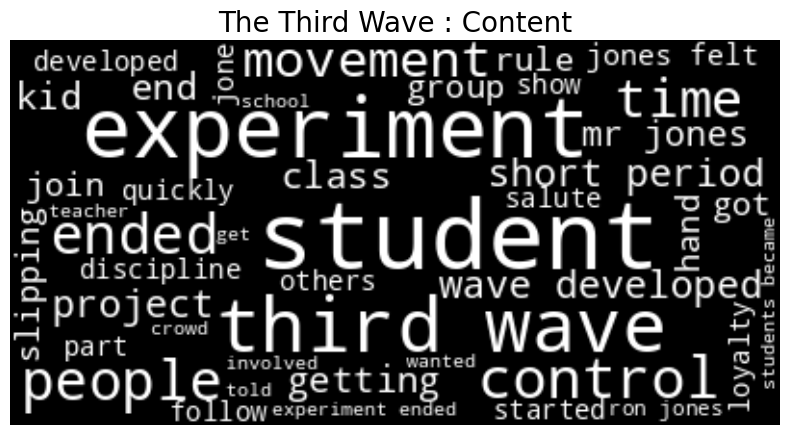

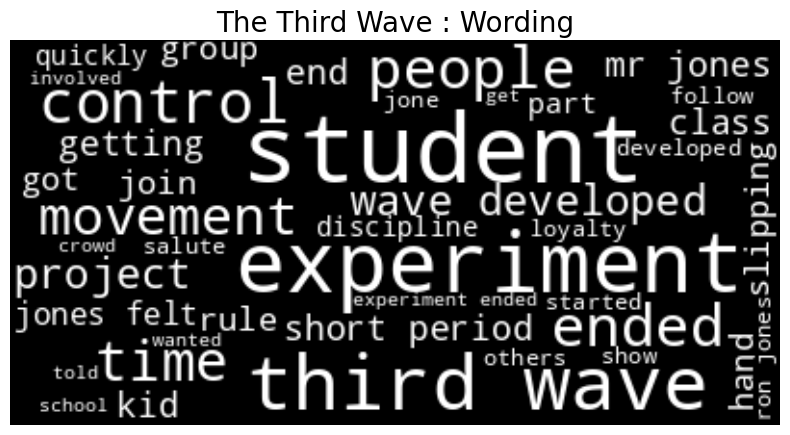

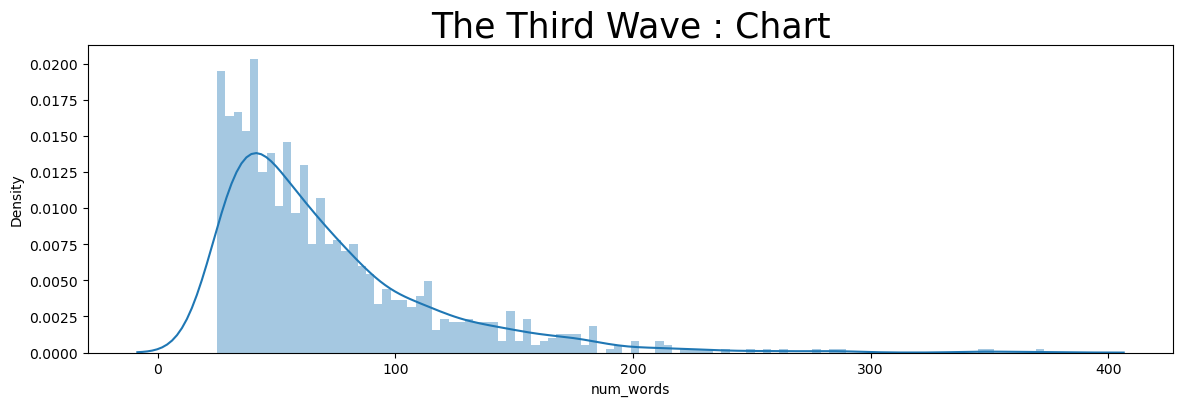

,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len
count,1103.0000,1103.0000,1103.0000,1103.0000,1103.0000,1103.0000,1103.0000,1103.0000
mean,71.1877,48.5376,401.2801,37.1469,0.0000,0.0000,0.0000,4.6117
std,45.3755,23.6326,260.2374,23.6456,0.0000,0.0000,0.0000,0.3306
min,25.0000,18.0000,116.0000,10.0000,0.0000,0.0000,0.0000,3.6071
25%,39.0000,31.0000,217.0000,20.0000,0.0000,0.0000,0.0000,4.3947
50%,58.0000,43.0000,324.0000,30.0000,0.0000,0.0000,0.0000,4.6087
75%,87.0000,59.0000,491.5000,47.0000,0.0000,0.0000,0.0000,4.8367
max,373.0000,190.0000,2168.0000,181.0000,0.0000,0.0000,0.0000,5.5526


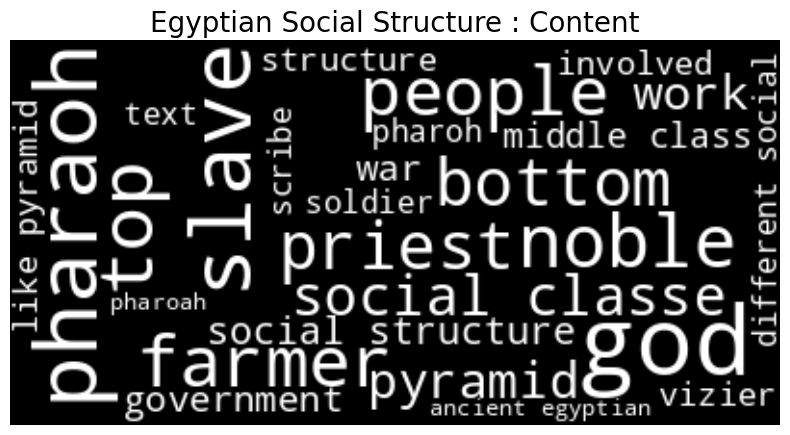

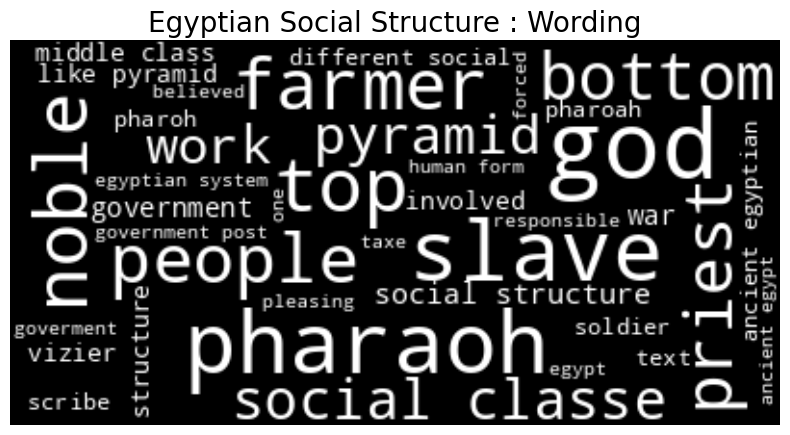

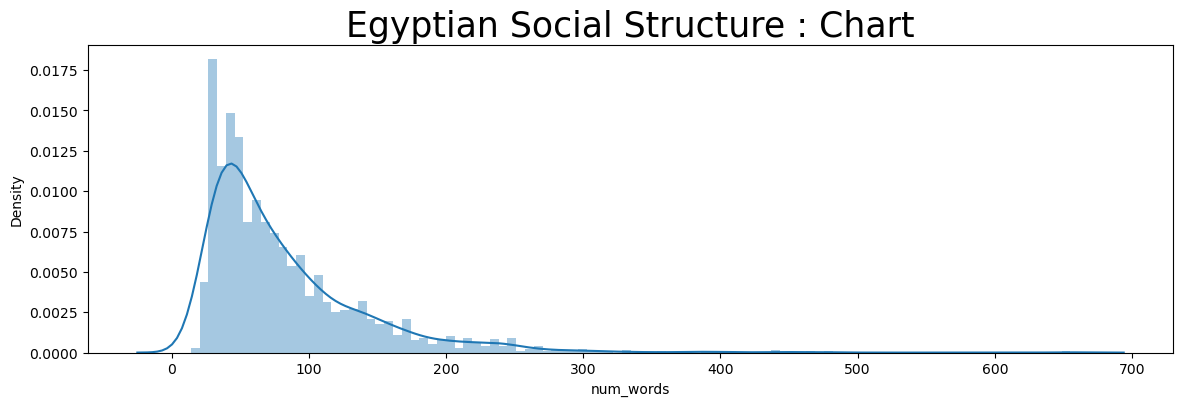

,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len
count,2009.0000,2009.0000,2009.0000,2009.0000,2009.0000,2009.0000,2009.0000,2009.0000
mean,82.0343,51.2524,469.3444,40.9607,0.0000,0.0000,0.0000,4.7077
std,59.3413,29.1023,343.4965,29.6273,0.0000,0.0000,0.0000,0.3791
min,14.0000,12.0000,85.0000,5.0000,0.0000,0.0000,0.0000,3.2791
25%,42.0000,30.0000,236.0000,20.0000,0.0000,0.0000,0.0000,4.4722
50%,64.0000,43.0000,359.0000,32.0000,0.0000,0.0000,0.0000,4.6986
75%,103.0000,64.0000,588.0000,53.0000,0.0000,0.0000,0.0000,4.9333
max,655.0000,267.0000,3819.0000,310.0000,0.0000,0.0000,0.0000,6.6667


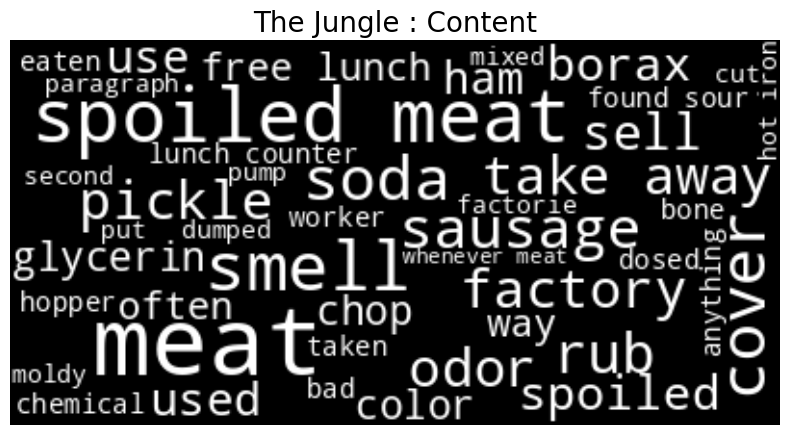

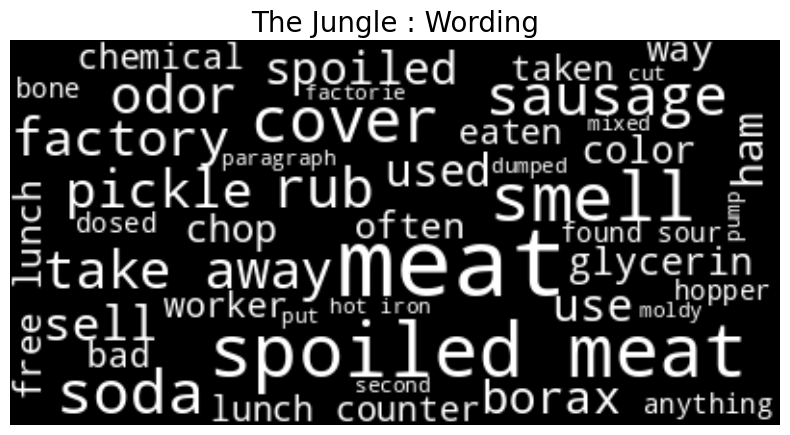

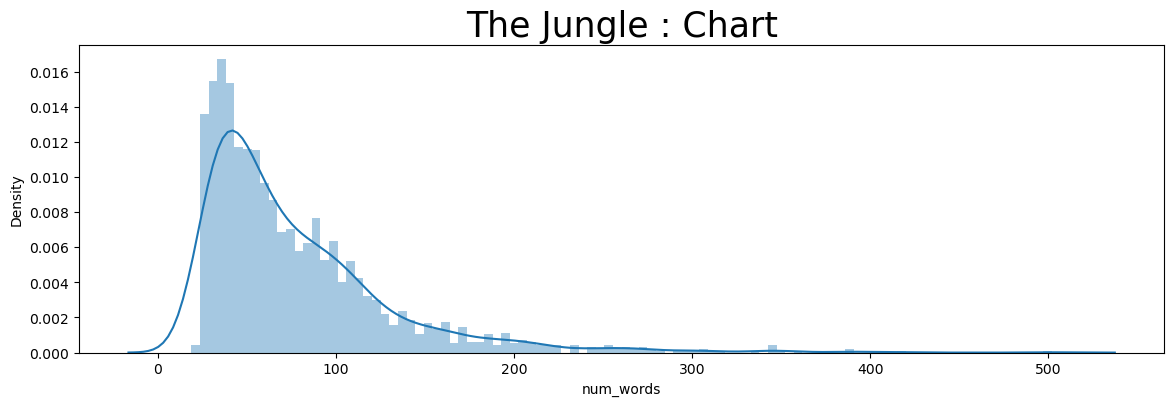

,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len
count,1996.0000,1996.0000,1996.0000,1996.0000,1996.0000,1996.0000,1996.0000,1996.0000
mean,77.4880,49.8262,401.9795,42.1879,0.0000,0.0000,0.0000,4.1634
std,53.7795,26.4114,285.4026,29.2967,0.0000,0.0000,0.0000,0.2939
min,19.0000,15.0000,84.0000,8.0000,0.0000,0.0000,0.0000,3.1481
25%,40.0000,30.0000,208.7500,22.0000,0.0000,0.0000,0.0000,3.9580
50%,61.0000,43.0000,317.0000,34.0000,0.0000,0.0000,0.0000,4.1514
75%,98.0000,62.0000,501.0000,54.0000,0.0000,0.0000,0.0000,4.3377
max,502.0000,211.0000,2659.0000,260.0000,0.0000,0.0000,0.0000,5.7419


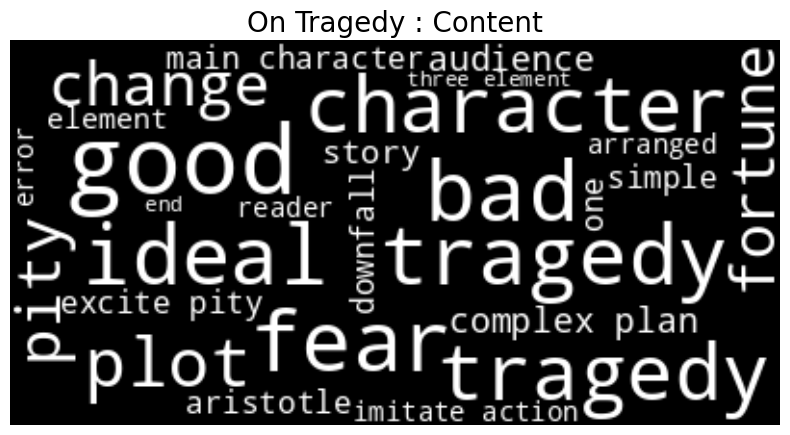

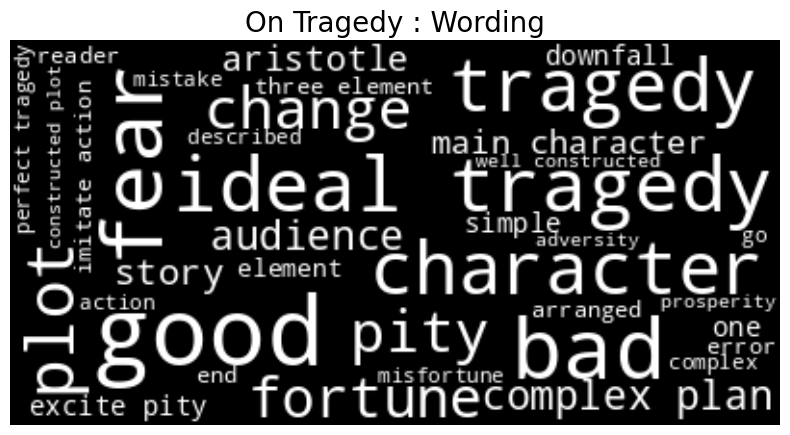

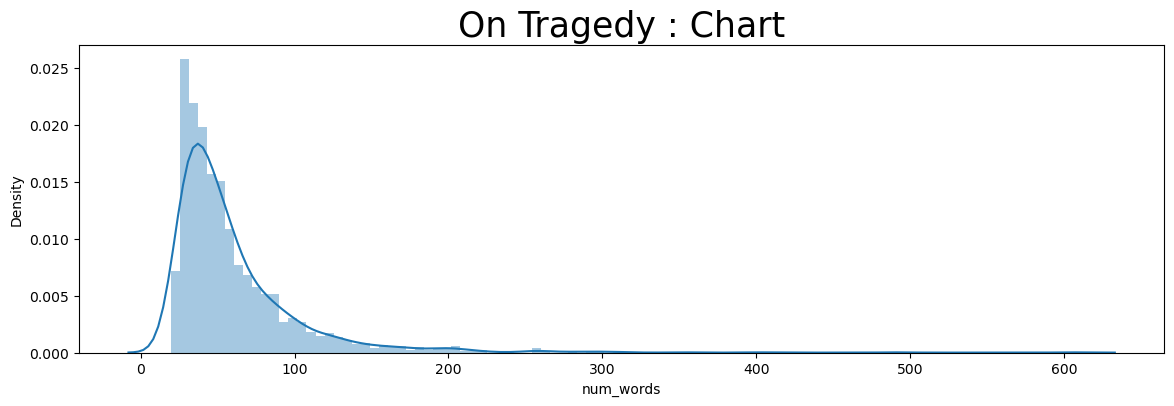

,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len
count,2057.0000,2057.0000,2057.0000,2057.0000,2057.0000,2057.0000,2057.0000,2057.0000
mean,59.9621,41.5134,337.4020,30.5022,0.0000,0.0000,0.0000,4.6198
std,42.7823,20.8651,244.4842,22.2652,0.0000,0.0000,0.0000,0.3227
min,20.0000,12.0000,112.0000,6.0000,0.0000,0.0000,0.0000,3.3889
25%,34.0000,28.0000,191.0000,17.0000,0.0000,0.0000,0.0000,4.4074
50%,47.0000,36.0000,266.0000,24.0000,0.0000,0.0000,0.0000,4.6148
75%,70.0000,48.0000,393.0000,36.0000,0.0000,0.0000,0.0000,4.8182
max,605.0000,269.0000,3503.0000,311.0000,0.0000,0.0000,0.0000,6.2800


In [29]:
for i, prompt_id in tqdm(enumerate(train_prompt_id_list)):
    if prompt_id == '39c16e':
        generate_word_cloud(df=train_processed, col_name='content', prompt='text', prompt_id=prompt_id ,title='On Tragedy : Content')
        generate_word_cloud(df=train_processed, col_name='wording', prompt='text', prompt_id=prompt_id ,title='On Tragedy : Wording')
        train_desc, test_desc = text_description(train_df=train_processed, test_df=test_processed, column='text', prompt_id=prompt_id)
        num_words_plot(df=train_processed, column='num_words', prompt_id=prompt_id, title='On Tragedy : Chart')
        display(train_desc)
        print()
    elif prompt_id == '3b9047':
        generate_word_cloud(df=train_processed, col_name='content', prompt='text', prompt_id=prompt_id , title='Egyptian Social Structure : Content')
        generate_word_cloud(df=train_processed, col_name='wording', prompt='text', prompt_id=prompt_id , title='Egyptian Social Structure : Wording')
        train_desc, test_desc = text_description(train_df=train_processed, test_df=test_processed, column='text', prompt_id=prompt_id)
        num_words_plot(df=train_processed, column='num_words', prompt_id=prompt_id, title='Egyptian Social Structure : Chart')
        display(train_desc)
        print()
    elif prompt_id == 'ebad26':
        generate_word_cloud(df=train_processed, col_name='content', prompt='text', prompt_id=prompt_id , title='The Jungle : Content')
        generate_word_cloud(df=train_processed, col_name='wording', prompt='text', prompt_id=prompt_id , title='The Jungle : Wording')
        train_desc, test_desc = text_description(train_df=train_processed, test_df=test_processed, column='text', prompt_id=prompt_id)
        num_words_plot(df=train_processed, column='num_words', prompt_id=prompt_id, title='The Jungle : Chart')
        display(train_desc)
        print()
    elif prompt_id == '814d6b':
        generate_word_cloud(df=train_processed, col_name='content', prompt='text', prompt_id=prompt_id , title='The Third Wave : Content')
        generate_word_cloud(df=train_processed, col_name='wording', prompt='text', prompt_id=prompt_id , title='The Third Wave : Wording')
        train_desc, test_desc = text_description(train_df=train_processed, test_df=test_processed, column='text', prompt_id=prompt_id)
        num_words_plot(df=train_processed, column='num_words', prompt_id=prompt_id, title='The Third Wave : Chart')
        display(train_desc)
        print()